In [28]:
import argparse
import pickle
import itertools

import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.utils.fixes import signature
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  


In [2]:
def ImbalancedDatasetSampler(x, y):
    # distribution of classes in the dataset
    label_to_count = {}
    for label in y['psi_group']:
        if label in label_to_count:
            label_to_count[label] += 1
        else:
            label_to_count[label] = 1

    # weight for each sample
    prob_lis = np.empty(y.shape[0])
    for key, count in label_to_count.items():
        prob_lis[y['psi_group'] == key] = 0.5 / count

    selected_idx = np.random.choice(
        np.arange(len(y)), replace=True, size=len(y), p=prob_lis)
    return x[selected_idx], y.iloc[selected_idx]

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
with open('../input/quantile/weight_quantile_rf_delta_data.pickle', 'rb') as fh:
    x, y, _ = pickle.load(fh)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=9487)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.125, random_state=9487)

In [6]:
x_train, y_train = ImbalancedDatasetSampler(x_train, y_train)

y_train = np.asarray(y_train['psi_group'], dtype='bool')
y_test = np.asarray(y_test['psi_group'], dtype='bool')
y_val = np.asarray(y_val['psi_group'], dtype='bool')

In [7]:
param_dist = {'booster': 'gbtree',
              'eta': 0.1,
              'n_estimators': 2000,
              'max_depth': 6,
              'colsample_bytree': 0.5,
              'objective': 'binary:logistic',
              'tree_method': 'gpu_exact'}
clf = XGBClassifier(**param_dist)

clf = clf.fit(x_train, y_train,
              eval_set=[(x_val, y_val)],
              eval_metric='logloss',
              early_stopping_rounds=5,
              verbose=True)

[0]	validation_0-logloss:0.681688
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.671823
[2]	validation_0-logloss:0.664014
[3]	validation_0-logloss:0.657244
[4]	validation_0-logloss:0.651459
[5]	validation_0-logloss:0.646883
[6]	validation_0-logloss:0.642914
[7]	validation_0-logloss:0.639216
[8]	validation_0-logloss:0.63641
[9]	validation_0-logloss:0.633922
[10]	validation_0-logloss:0.631324
[11]	validation_0-logloss:0.629335
[12]	validation_0-logloss:0.627504
[13]	validation_0-logloss:0.625908
[14]	validation_0-logloss:0.624523
[15]	validation_0-logloss:0.622955
[16]	validation_0-logloss:0.621669
[17]	validation_0-logloss:0.620604
[18]	validation_0-logloss:0.619631
[19]	validation_0-logloss:0.618698
[20]	validation_0-logloss:0.616952
[21]	validation_0-logloss:0.61545
[22]	validation_0-logloss:0.614484
[23]	validation_0-logloss:0.613953
[24]	validation_0-logloss:0.613406
[25]	validation_0-logloss:0.612559
[26]	validation_0-logloss:0.611995


In [9]:
print('Accuracy on train dataset: ',
      accuracy_score(y_train, clf.predict(x_train)))

y_pred = clf.predict(x_test)
prob = clf.predict_proba(x_test)
print('Accuracy on test dataset: ', accuracy_score(y_test, y_pred))

Accuracy on train dataset:  0.8509048325133113
Accuracy on test dataset:  0.7189951052662618


In [16]:
prob[:,1]

array([0.0562522 , 0.355437  , 0.47282395, ..., 0.537393  , 0.5318507 ,
       0.4028653 ], dtype=float32)

In [17]:
p, r, _ = precision_recall_curve(y_test, prob[:,1])

In [21]:
auc(r, p)

0.6276633148310639

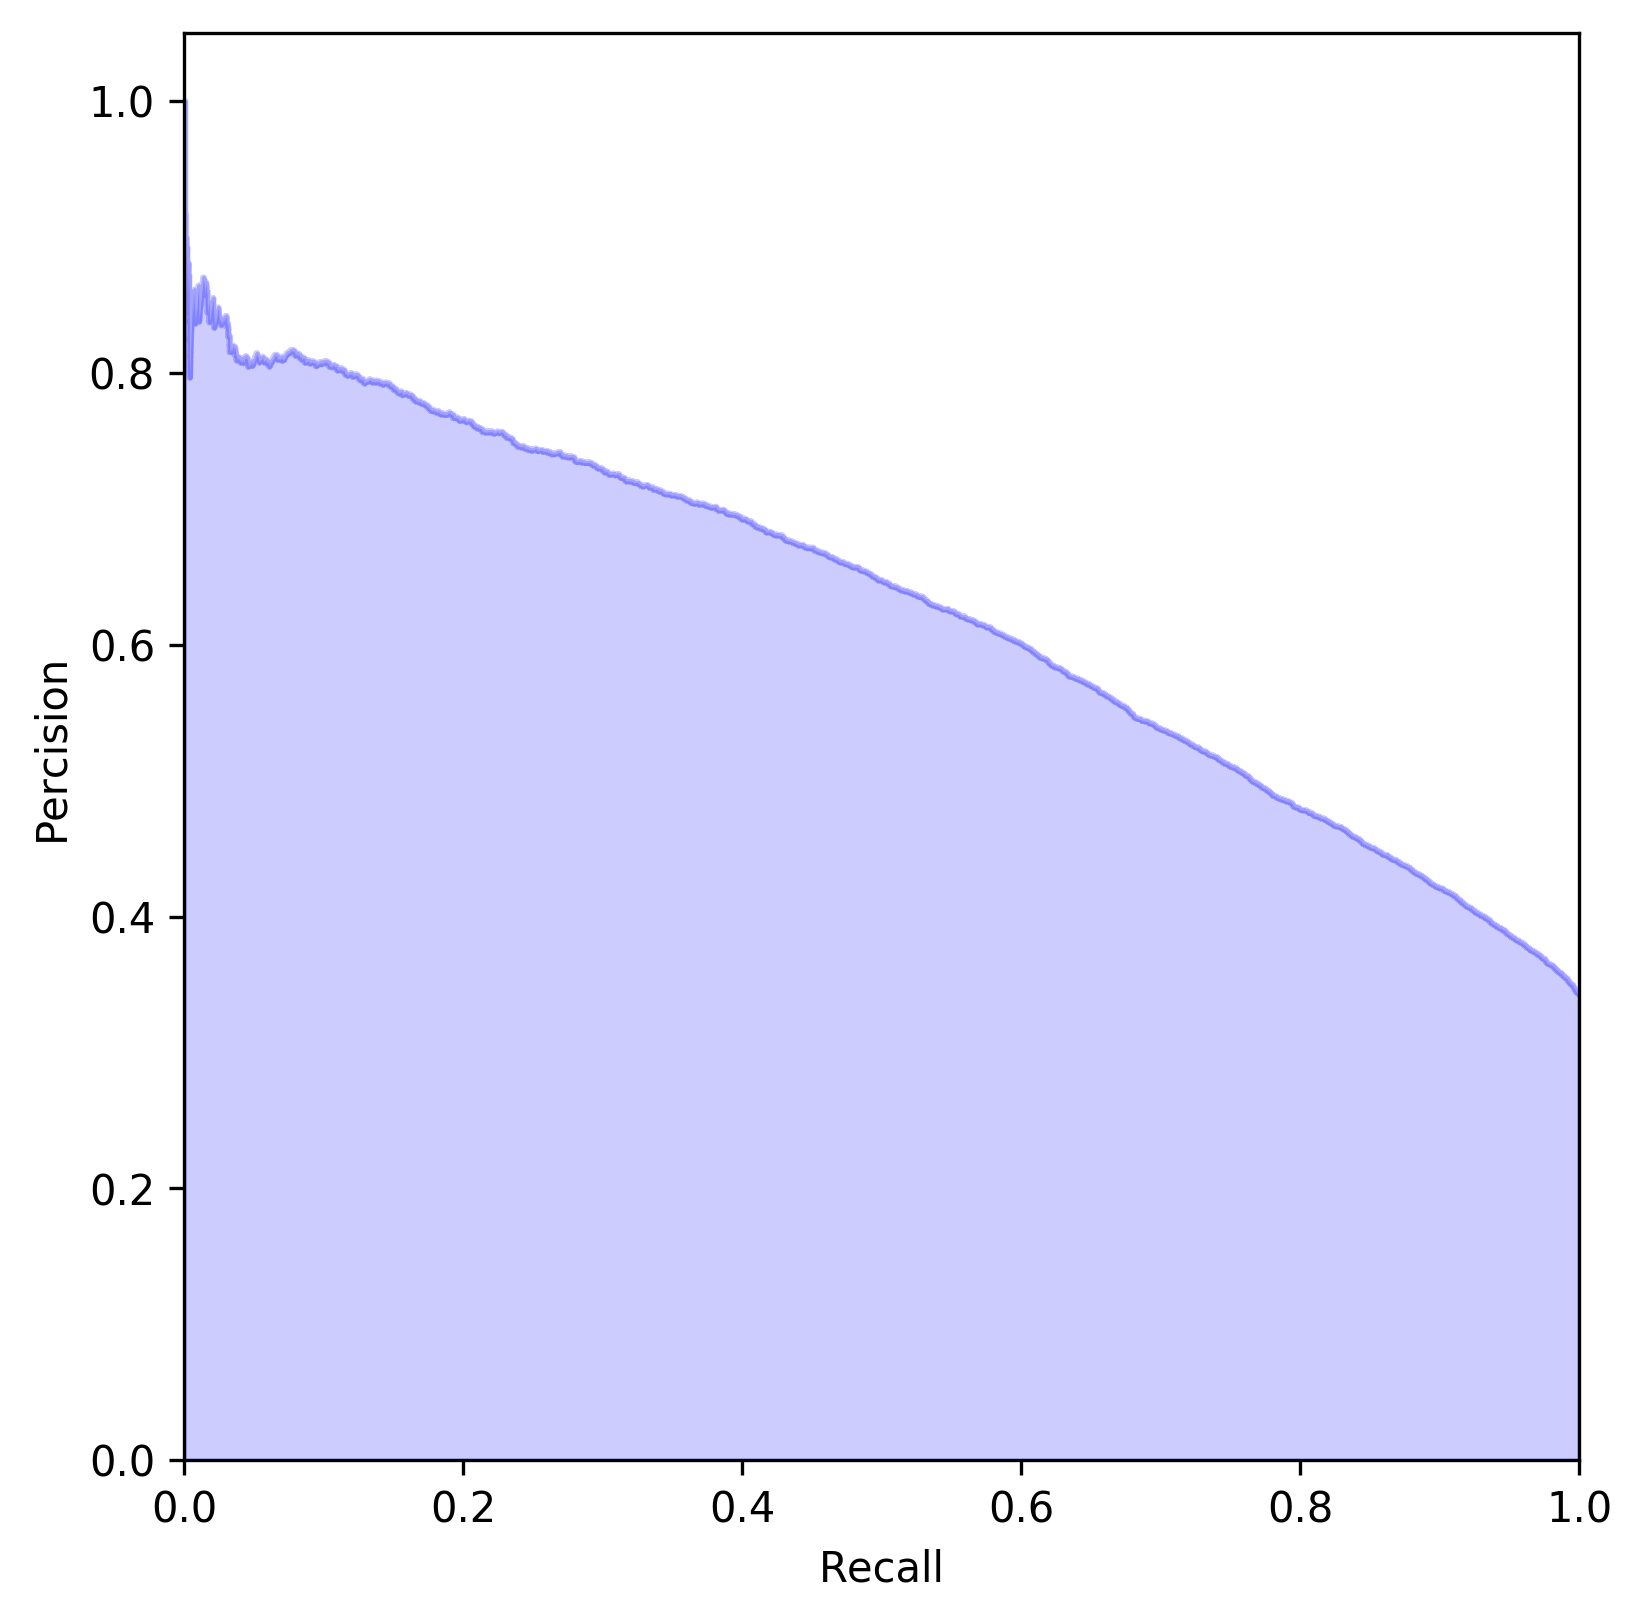

In [20]:
plt.figure(figsize=(6, 6.3), dpi=300)
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(r, p, color='b', alpha=0.2, where='post')
plt.fill_between(r, p, alpha=0.2, color='b')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Percision')
plt.show()

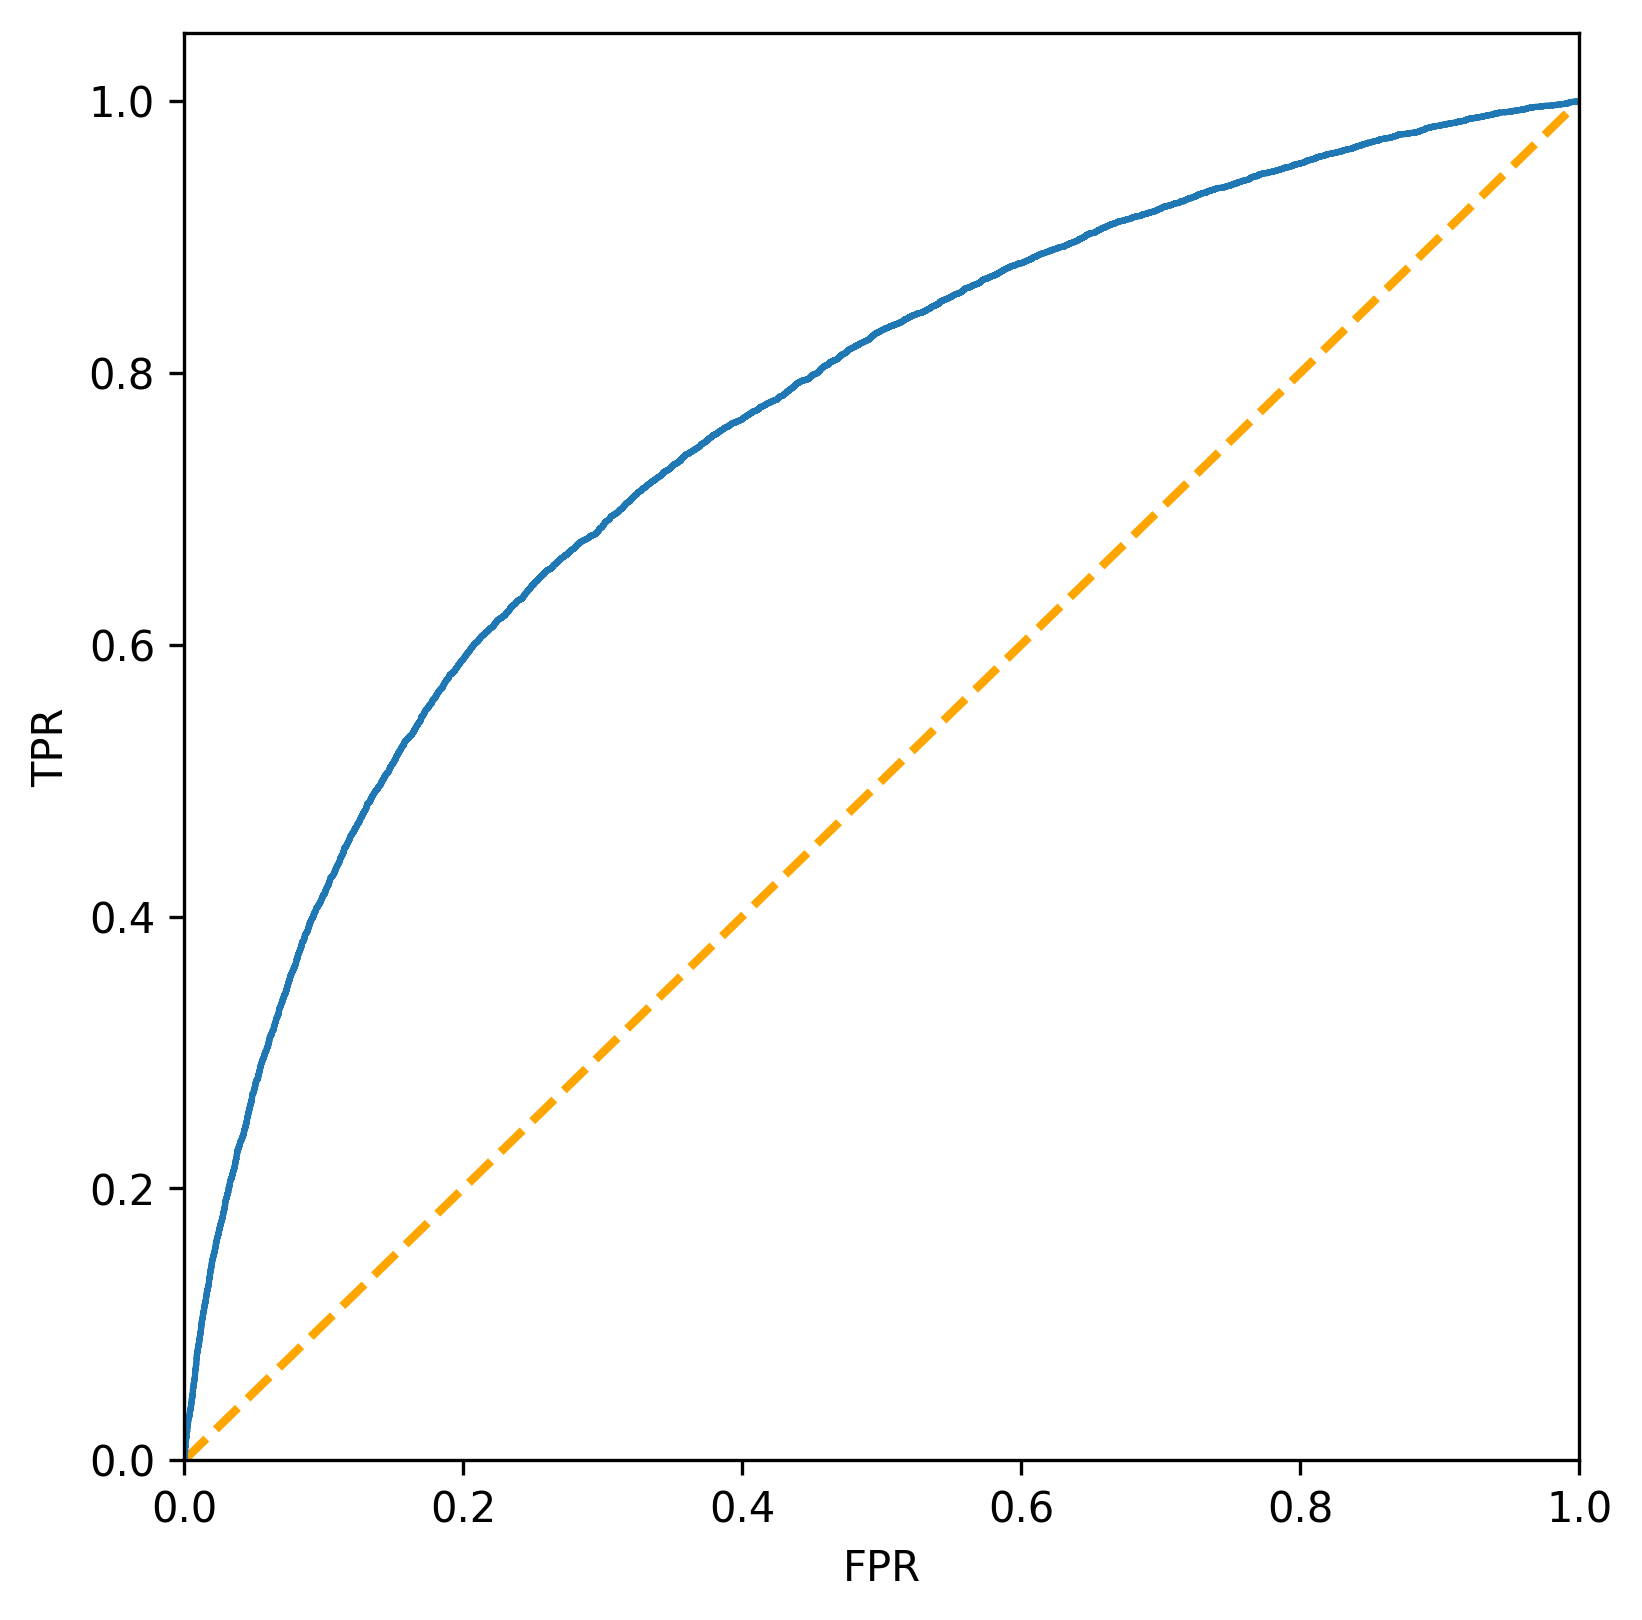

In [23]:
fpr, tpr, _ = roc_curve(y_test, prob[:,1])
plt.figure(figsize=(6, 6.3), dpi=300)
plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [24]:
auc(fpr, tpr)

0.7592285527610392

Normalized confusion matrix
[[0.76874776 0.23125224]
 [0.37648477 0.62351523]]


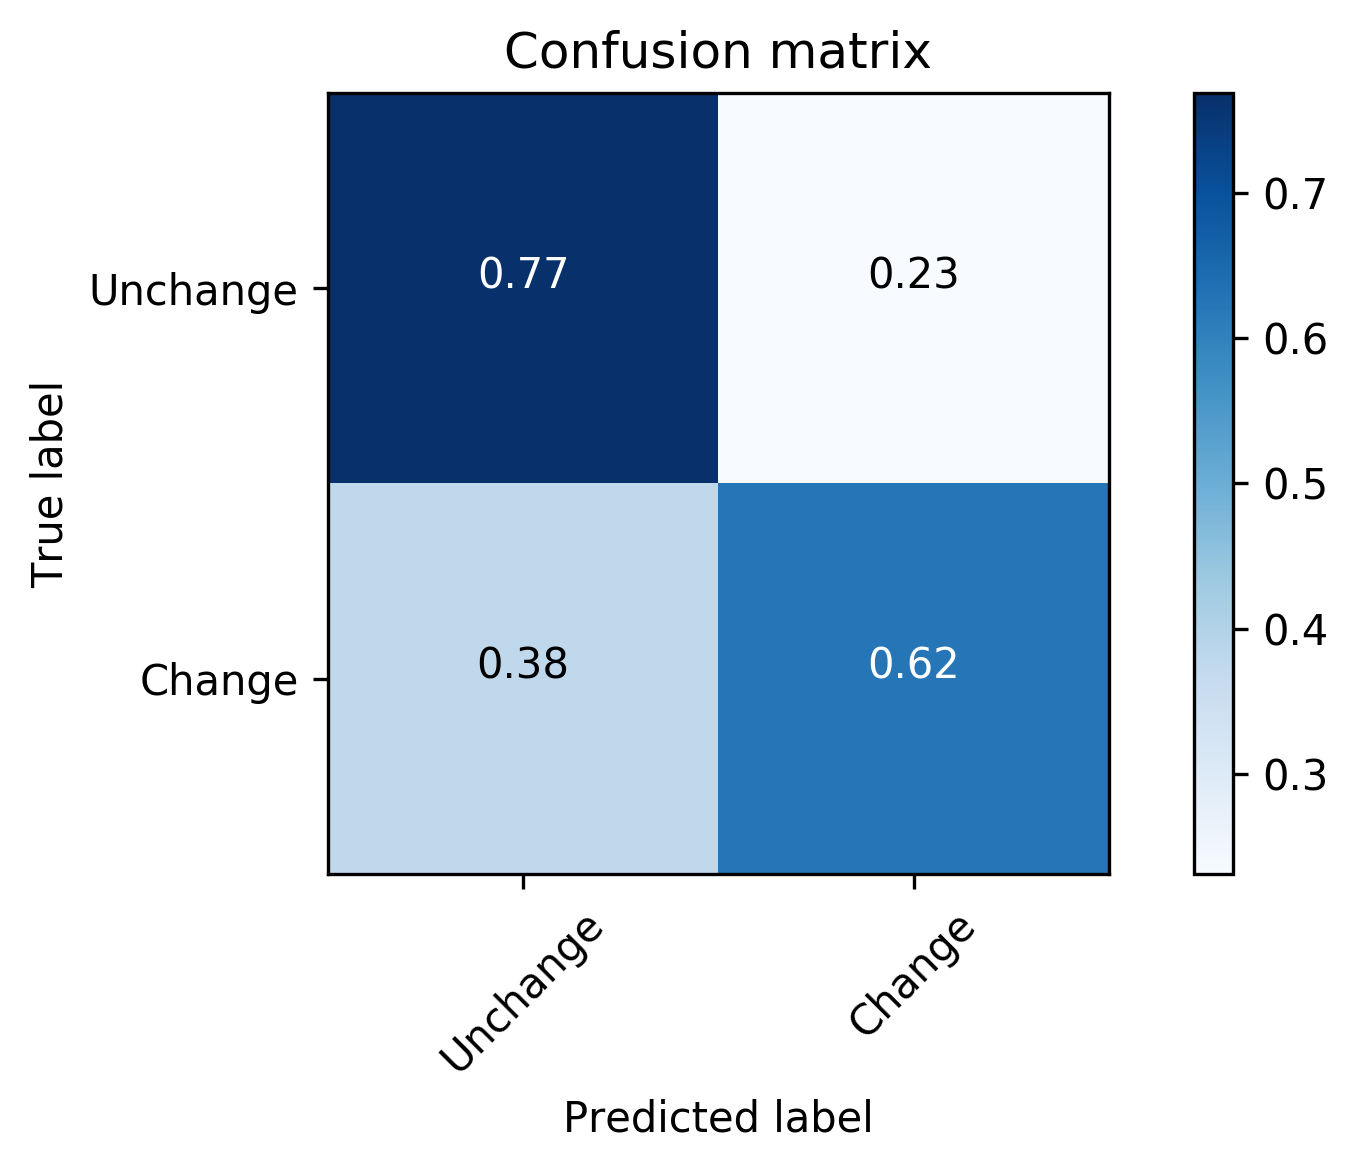

In [29]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(dpi=300)
plot_confusion_matrix(cm, classes=['Unchange', 'Change'], normalize=True)
plt.tight_layout()
plt.savefig('confusion_matrix_xgb.png')